# SIGMA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega_{surf} + R_{diff,R2} \end{equation*}
## **SODA 3.4.2**

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [1]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [2]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.81cbdb43a0a14c3891c966902ca7f6e7 Dashboard: /services/dask-gateway/clusters/staging.81cbdb43a0a14c3891c966902ca7f6e7/status,Cluster Workers: 30 Cores: 60 Memory: 257.70 GB


In [30]:
client.close()
cluster.close()

In [3]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from fastjmd95 import jmd95numba
%matplotlib inline
xr.set_options(display_style='text');

In [4]:
url_ocean = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ocean_or'
fs = gcsfs.GCSFileSystem()
ocean = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True, decode_times=False)

In [5]:
path = 'pangeo-tmp/stb2145/SODA/datasets/'

transport = xr.open_zarr(gcsfs.GCSMap(path + 'transport_wg.zarr'))
cells = xr.open_zarr(gcsfs.GCSMap(path + 'cells_wg.zarr'))
surf = xr.open_zarr(gcsfs.GCSMap(path + 'surf_terms.zarr'))
totend = xr.open_zarr(gcsfs.GCSMap(path + 'totend.zarr'))

## <font color='Green'>Fix time for ocean ds</font>
(this is also done in `zarr-SODA-datasets.ipynb`)

In [6]:
#ds.time.data[-1] + 5 to get stop value
data = np.arange(0, 9850, 5)
time_copy = ocean.time.copy(deep=False)
time_coord = time_copy.coords.to_dataset().reset_coords() 
#^separating time coord to be a ds itself so that I can change values of it in next line but keep encoded time info
time_coord_copy = time_coord.time.copy(data=data) 
#^rewriting the coord data for self-created data
time_new_data_coord = time_copy.assign_coords(time=time_coord_copy) 
#^assigning new values for coord to copied time array
time_new = time_new_data_coord.to_dataset(name = 'time_new')
time_new_dec = xr.decode_cf(time_new, decode_coords=True).time_new
ds_new = ocean.drop_vars('time').assign_coords({'time': ('time', time_new_dec.time.values)})
ds_new['time'] = ds_new.time.assign_attrs(ocean.time.attrs)

In [7]:
ds = ds_new

## <font color='Green'>Slice to WG region</font>

In [8]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 169 #-62.01972704
left_lon =  859 #-65.12
right_lon = 1240 #30.12

lower_lat_u = 0 #-79.96821565
upper_lat_u = 169 #-61.96096874 python is right exclusive so will have -62.0 in array
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [9]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

In [10]:
ds_wg = ds.isel(**lat_range, **lon_range)

# <font color='Green'>\begin{equation*} \sigma_2\ term \end{equation*} </font>

In [12]:
pref = 2000

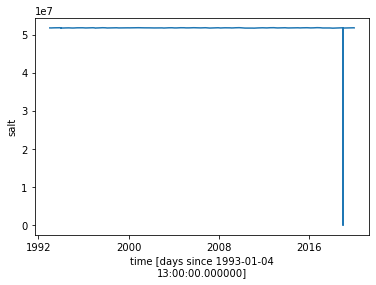

In [19]:
ds_wg.salt.sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot()

In [13]:
mask = ds_wg.time != ds_wg.time.sel(time='2018-12-24').values
salt_mask = ds_wg.salt.where(mask)#.load()
temp_mask = ds_wg.temp.where(mask)#.load()

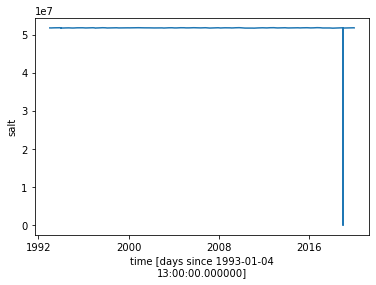

In [57]:
salt_mask.sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot()
#still shows dip bc of .sum() but mask does work!

In [20]:
salt_mask.dtype

dtype('float32')

In [14]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.40853104aa9c41d78b293961c2e412ba Dashboard: /services/dask-gateway/clusters/staging.40853104aa9c41d78b293961c2e412ba/status,Cluster Workers: 1 Cores: 2 Memory: 8.59 GB


In [14]:
#USE THIS!!
import fastjmd95
sigma2 = fastjmd95.rho(salt_mask, temp_mask, pref)

In [16]:
sigma2

<xarray.DataArray (time: 1970, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<transpose, shape=(1970, 50, 169, 381), dtype=float64, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00

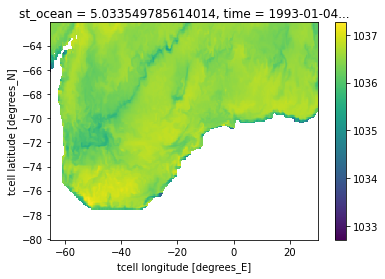

In [22]:
sigma2[0,0].plot()

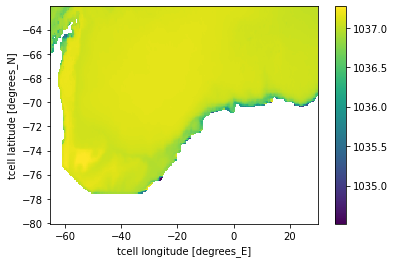

In [24]:
sigma2.mean(dim=['time', 'st_ocean']).plot()

In [25]:
sigma2.nbytes/1e9

50.738532

In [ ]:
sigma2.mean(dim=['time', 'st_ocean']).plot.hist()

### Volume-weighted $\frac{\partial{\sigma_2}}{\partial t} =$ _tottend_truth_

In [15]:
drhodt = fastjmd95.drhodt(salt_mask, temp_mask, pref)
drhods = fastjmd95.drhods(salt_mask, temp_mask, pref)

In [16]:
vol = cells.dx_interp * cells.dy_u * cells.dz

In [17]:
totttend_truth = (totend.totttend * drhodt[1:])# * vol)#.load()

In [18]:
totstend_truth = (totend.totstend * drhods[1:])# * vol)#.load()

In [19]:
delta_sigma = sigma2.isel(time=-1) - sigma2.isel(time=0)
total_time = (sigma2.time[-1] - sigma2.time[0]).astype('f8')*1e-9
totend_truth = (delta_sigma * vol) / total_time

In [20]:
dt_values = (surf.time.diff('time') / 1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'], 
                  coords={'time': (['time'], surf.time.values[1:])}) #shaves off first time stamp in `surf.time`
surf.coords['dt'] = dt

In [21]:
surf.dt[1:]

<xarray.DataArray 'dt' (time: 1969)>
array([432000., 432000., 432000., ..., 432000., 432000., 432000.],
      dtype=float32)
Coordinates:
    dt       (time) float32 4.32e+05 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05
  * time     (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00

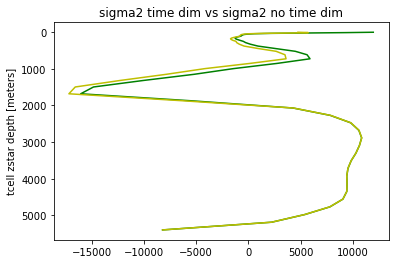

In [22]:
(sigma2.diff(dim='time')*vol/surf.dt[1:]).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False, color='green')
totend_truth.sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, color='y')
plt.title('sigma2 time dim vs sigma2 no time dim');

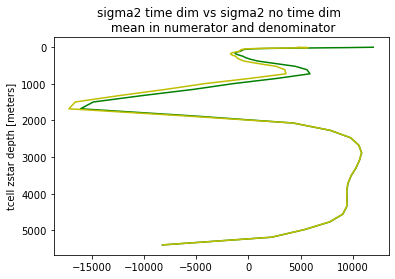

In [67]:
((sigma2.diff(dim='time')*vol).mean(dim='time')/surf.dt[1:].mean(dim='time')).sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, 
                                                                                                               color='green')
totend_truth.sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, color='y')
plt.title('sigma2 time dim vs sigma2 no time dim \n mean in numerator and denominator');

In [23]:
client.restart()

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.81cbdb43a0a14c3891c966902ca7f6e7 Dashboard: /services/dask-gateway/clusters/staging.81cbdb43a0a14c3891c966902ca7f6e7/status,Cluster Workers: 30 Cores: 60 Memory: 257.70 GB


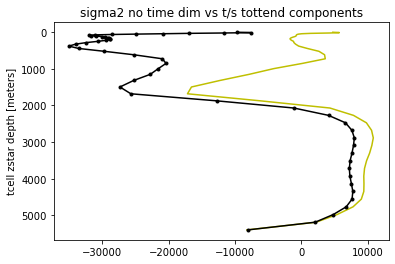

In [140]:
totend_truth.sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, color='y')
(totttend_truth + totstend_truth).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False, color='k', marker='.')
plt.title('sigma2 no time dim vs t/s tottend components');

In [73]:
((sigma2.diff(dim='time')*vol).mean(dim='time')/surf.dt[1:].mean(dim='time')).sum(dim=['yt_ocean', 'xt_ocean'])

<xarray.DataArray (st_ocean: 50)>
dask.array<sum-aggregate, shape=(50,), dtype=float64, chunksize=(50,), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03

In [74]:
(totttend_truth + totstend_truth).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time')

<xarray.DataArray (st_ocean: 50)>
dask.array<mean_agg-aggregate, shape=(50,), dtype=float64, chunksize=(50,), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03

In [76]:
totttend_truth

<xarray.DataArray (time: 1969, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<mul, shape=(1969, 50, 169, 381), dtype=float64, chunksize=(1, 50, 169, 191), chunktype=numpy.ndarray>
Coordinates:
    dt        (time) float32 dask.array<chunksize=(1969,), meta=np.ndarray>
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [78]:
sigma2.diff(dim='time')

<xarray.DataArray (time: 1969, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<sub, shape=(1969, 50, 169, 381), dtype=float64, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00

In [ ]:
((sigma2.diff(dim='time')*vol).mean(dim='time')/surf.dt[1:].mean(dim='time')).sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', 
                                                                                                               yincrease=False, color='y')
(totttend_truth + totstend_truth).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False, color='k', marker='.')
plt.title('sigma2 time dim vs t/s tottend components');

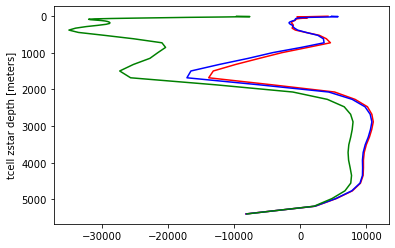

In [24]:
((sigma2.diff(dim='time')*vol).mean(dim='time')/surf.dt[1:].mean(dim='time')).sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', 
                                                                                                               yincrease=False, color='red')
totend_truth.sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, color='blue')
(totttend_truth + totstend_truth).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False, color='green');

In [25]:
totend_truth = ((sigma2.diff(dim='time') * vol) / surf.dt[1:])#.load()

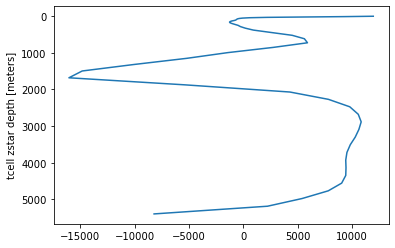

In [88]:
totend_truth.sum(['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False)

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-\sigma-truth} + R1 \end{equation*} </font>

In [26]:
client.restart()

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.81cbdb43a0a14c3891c966902ca7f6e7 Dashboard: /services/dask-gateway/clusters/staging.81cbdb43a0a14c3891c966902ca7f6e7/status,Cluster Workers: 30 Cores: 60 Memory: 257.70 GB


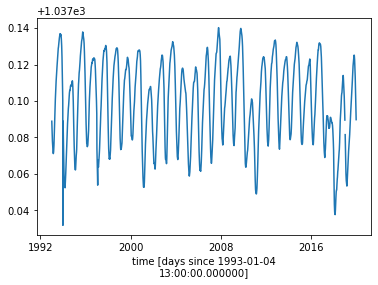

In [101]:
sigma2.mean(dim=['xt_ocean', 'yt_ocean', 'st_ocean']).plot()

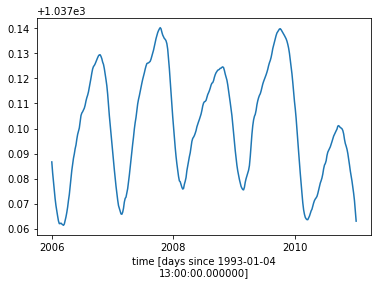

In [105]:
#SOSE time period
#density avged over volume gets denser in middle of the year (AA winter) and lighter around spring/summer
sigma2.sel(time=slice('2006', '2010')).mean(dim=['xt_ocean', 'yt_ocean', 'st_ocean']).plot()

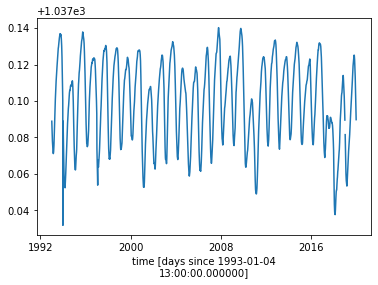

In [106]:
sigma2.sel(time=slice('1980', '2019')).mean(dim=['xt_ocean', 'yt_ocean', 'st_ocean']).plot()

In [107]:
sigma2.min().values

array(1032.01930673)

In [108]:
sigma2.max().values

array(1039.03267855)

In [27]:
# define bins (ECCO & SOSE bin size 1000)
delta_sigma = 0.01
sigma_bins = np.arange(1032.0, 1039.0, delta_sigma)

In [28]:
sigma_bins.size

700

In [111]:
sigma2.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00

In [112]:
vol.coords

Coordinates:
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03

In [24]:
client.restart()

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.40853104aa9c41d78b293961c2e412ba Dashboard: /services/dask-gateway/clusters/staging.40853104aa9c41d78b293961c2e412ba/status,Cluster Workers: 9 Cores: 18 Memory: 77.31 GB


In [146]:
totend.totttend

<xarray.DataArray 'totttend' (time: 1969, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<xarray-totttend, shape=(1969, 50, 169, 381), dtype=float64, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
    dt        (time) float32 dask.array<chunksize=(1969,), meta=np.ndarray>
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [147]:
sigma2

<xarray.DataArray (time: 1970, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<transpose, shape=(1970, 50, 169, 381), dtype=float64, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00

In [30]:
sigma_dist = histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=vol.fillna(0.), dim=['xt_ocean', 'yt_ocean', 'st_ocean']).load()

In [31]:
sigma_dist

<xarray.DataArray 'histogram_sigma2' (time: 1970, sigma2_bin: 699)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03

(1037.0, 1037.3)

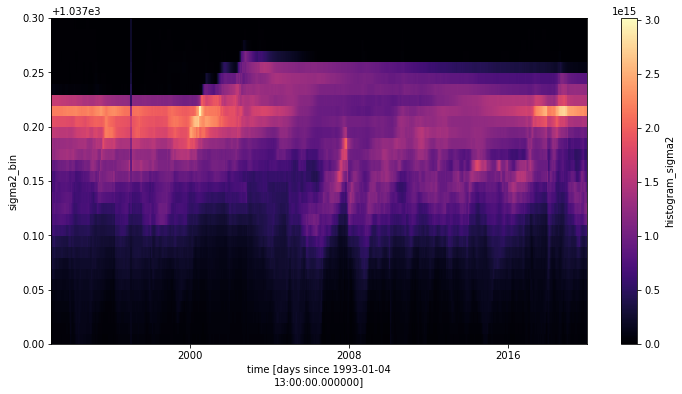

In [36]:
sigma_dist.where(mask).plot(x='time', figsize=(12, 6), cmap='magma')
plt.ylim(1037, 1037.3)

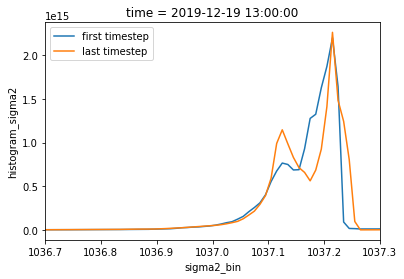

In [37]:
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1036.7, 1037.3);

(1037.5, 1036.4)

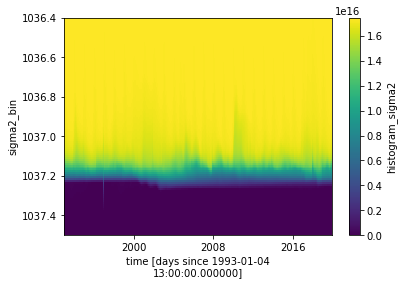

In [38]:
# cumulative volume
V = sigma_dist.isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
V.where(mask).transpose().plot()
plt.ylim(1037.5, 1036.4)

In [39]:
V

<xarray.DataArray 'histogram_sigma2' (time: 1970, sigma2_bin: 699)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.74516139e+16, 1.74516139e+16, 1.74516139e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.74516139e+16, 1.74516139e+16, 1.74516139e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.74516139e+16, 1.74516139e+16, 1.74516139e+16],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.74516139e+16, 1.74516139e+16, 1.74516139e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.74516139e+16, 1.74516139e+16, 1.74516139e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.74516139e+16, 1.74516139e+16, 1.74516139e+16]])
Coordinates:
  * time        (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.039e+03 1.039e+03 ... 1.032e+03 1.032e+03

(1037.5, 1037.0)

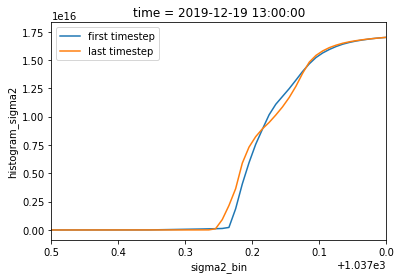

In [41]:
#waters with densities up to 1037.0 became lost volume and moved into denser sigma bins?
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037.5, 1037)

In [42]:
delta_V = V.diff(dim='time')

In [43]:
delta_V

<xarray.DataArray 'histogram_sigma2' (time: 1969, sigma2_bin: 699)>
array([[  0.,   0.,   0., ...,   8.,   8.,   8.],
       [  0.,   0.,   0., ..., -18., -18., -18.],
       [  0.,   0.,   0., ...,  22.,  22.,  22.],
       ...,
       [  0.,   0.,   0., ...,  -8.,  -8.,  -8.],
       [  0.,   0.,   0., ...,  16.,  16.,  16.],
       [  0.,   0.,   0., ...,   4.,   4.,   4.]])
Coordinates:
  * time        (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.039e+03 1.039e+03 ... 1.032e+03 1.032e+03

In [45]:
surf.dt[1:]

<xarray.DataArray 'dt' (time: 1969)>
array([432000., 432000., 432000., ..., 432000., 432000., 432000.],
      dtype=float32)
Coordinates:
    dt       (time) float32 4.32e+05 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05
  * time     (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00

## $\frac{\partial \mathcal{V}}{\partial t}$

In [72]:
dVdt = (delta_V / surf.dt[1:]).drop('dt')

In [73]:
dVdt

<xarray.DataArray (time: 1969, sigma2_bin: 699)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.85185185e-05,  1.85185185e-05,  1.85185185e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.16666667e-05, -4.16666667e-05, -4.16666667e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.09259259e-05,  5.09259259e-05,  5.09259259e-05],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.85185185e-05, -1.85185185e-05, -1.85185185e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.70370370e-05,  3.70370370e-05,  3.70370370e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.25925926e-06,  9.25925926e-06,  9.25925926e-06]])
Coordinates:
  * time        (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.039e+03 1.039e+03 ... 1.032e+03 1.032e+03

(1036.0, 1037.3)

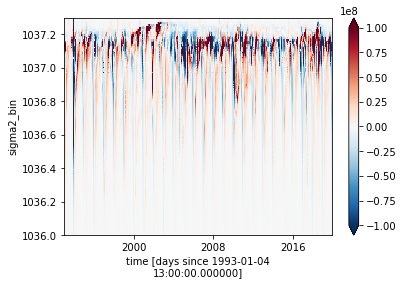

In [55]:
dVdt.where(mask).plot(x='time', vmax=1e8)
plt.ylim(1036, 1037.3)

(1036.0, 1037.3)

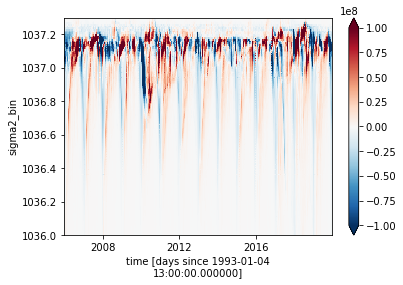

In [56]:
dVdt.where(mask).sel(time=slice('2006', '2019')).plot(x='time', vmax=1e8)
plt.ylim(1036, 1037.3)

## $\Omega_{total}$

In [57]:
totend_truth.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
    dt        (time) float32 4.32e+05 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05

In [58]:
sigma2[1:].coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00

In [60]:
omega_total = - histogram(sigma2[1:].rename('sigma2'), bins=[sigma_bins],
                          weights=totend_truth.fillna(0.),
                          dim=['yt_ocean', 'xt_ocean', 'st_ocean']) / (- delta_sigma)

In [61]:
omega_total.nbytes/1e9

0.011010648

In [62]:
omega_total.load()

<xarray.DataArray 'histogram_sigma2' (time: 1969, sigma2_bin: 699)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03

In [63]:
dVdt

<xarray.DataArray (time: 1969, sigma2_bin: 699)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.85185185e-05,  1.85185185e-05,  1.85185185e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.16666667e-05, -4.16666667e-05, -4.16666667e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.09259259e-05,  5.09259259e-05,  5.09259259e-05],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.85185185e-05, -1.85185185e-05, -1.85185185e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.70370370e-05,  3.70370370e-05,  3.70370370e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.25925926e-06,  9.25925926e-06,  9.25925926e-06]])
Coordinates:
  * time        (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.039e+03 1.039e+03 ... 1.032e+03 1.032e+03
    dt          (time) float32 4.32e+05 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05

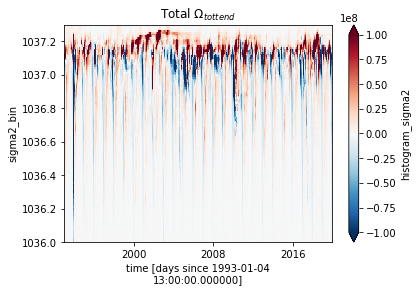

In [67]:
omega_total.plot(x='time', vmax=1e8)
plt.ylim(ymin=1036, ymax=1037.3)
plt.title(r'Total $\Omega_{tottend}$');

## <font color='Green'>\begin{equation*} R1 = \frac{\partial \mathcal{V}}{\partial t} - \Omega_{total} \end{equation*} (Discretization of sigma layers) </font>

In [74]:
dVdt.coords

Coordinates:
  * time        (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.039e+03 1.039e+03 ... 1.032e+03 1.032e+03

In [69]:
omega_total.coords

Coordinates:
  * time        (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03

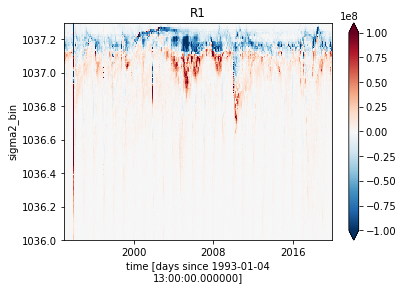

In [75]:
R1 = dVdt - omega_total

R1.where(mask).plot(x='time', vmax=1e8)
plt.ylim(ymin=1036, ymax=1037.3)
plt.title('R1');

In [76]:
dVdt

<xarray.DataArray (time: 1969, sigma2_bin: 699)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.85185185e-05,  1.85185185e-05,  1.85185185e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.16666667e-05, -4.16666667e-05, -4.16666667e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.09259259e-05,  5.09259259e-05,  5.09259259e-05],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.85185185e-05, -1.85185185e-05, -1.85185185e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.70370370e-05,  3.70370370e-05,  3.70370370e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.25925926e-06,  9.25925926e-06,  9.25925926e-06]])
Coordinates:
  * time        (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.039e+03 1.039e+03 ... 1.032e+03 1.032e+03

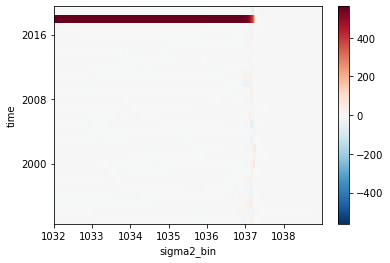

In [86]:
(dVdt/1e6).where(mask).resample(time='AS').mean(dim='time').plot()

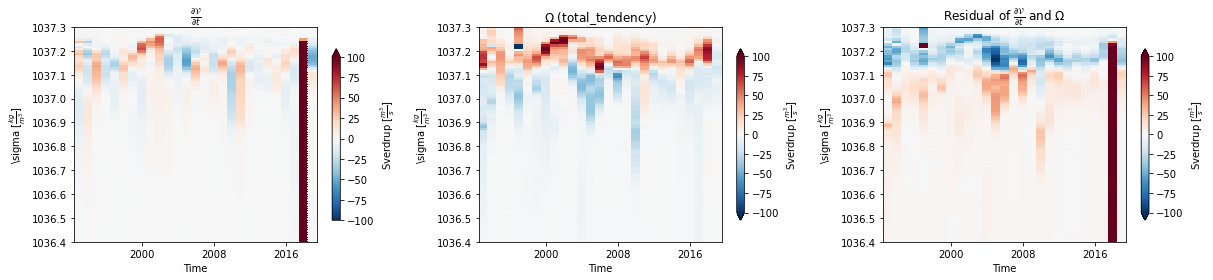

In [90]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(17, 4), sharex=True)

(dVdt/1e6).where(mask).resample(time='AS').mean(dim='time').plot(x='time', ax=ax0, vmax=100,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')#, fontsize=14)
ax0.set_xlabel('Time')#, fontsize=14)
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$')#, fontsize=24)
ax0.set_ylim(1036.4, 1037.3)

(omega_total/1e6).where(mask).resample(time='AS').mean(dim='time').plot(x='time', ax=ax1, vmax=100,
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax1.set_xlabel('Time')#, fontsize=14)
ax1.set_title('$\Omega$ (total_tendency)')
ax1.set_ylim(1036.4, 1037.3)

(R1/1e6).where(mask).resample(time='AS').mean(dim='time').plot(x='time', ax=ax2, vmax=100,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax2.set_xlabel('Time')
ax2.set_title(r'Residual of $\frac{\partial \mathcal{V}}{\partial t}$ and $\Omega$')
ax2.set_ylim(1036.4, 1037.3)

plt.tight_layout();

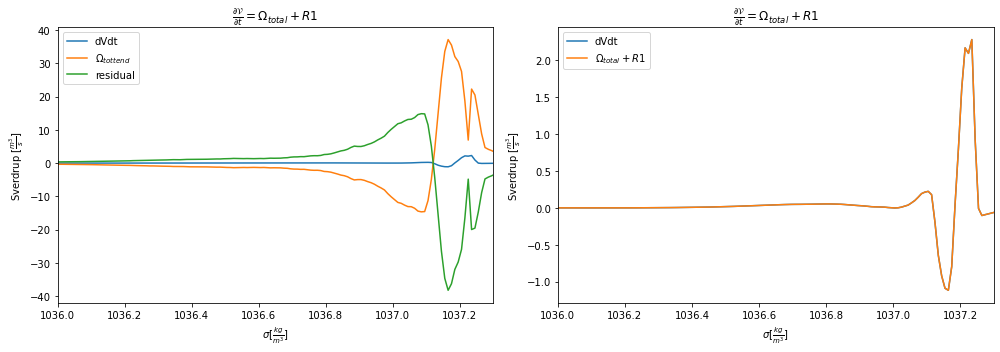

In [92]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=ax0)
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax0)
(R1/1e6).mean(dim='time').plot(label='residual', ax=ax0)
ax0.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax0.set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
ax0.legend()
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
ax0.set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=ax1)
((omega_total + R1)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=ax1)
ax1.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax1.set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
ax1.legend()
ax1.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
ax1.set_xlim(1036, 1037.3)

plt.tight_layout();

## <span style='color:Green'> \begin{equation*} \Omega_{surf} \end{equation*}

In [93]:
surf

<xarray.Dataset>
Dimensions:             (st_ocean: 50, time: 1970, xt_ocean: 381, yt_ocean: 169)
Coordinates:
    dt                  (time) float32 nan 4.32e+05 ... 4.32e+05 4.32e+05
  * st_ocean            (st_ocean) float64 5.034 15.1 ... 5.185e+03 5.395e+03
  * time                (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:0...
  * xt_ocean            (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.62 29.88
  * yt_ocean            (yt_ocean) float64 -80.02 -79.92 ... -62.25 -62.14
Data variables:
    surf_flux_conv_SLT  (time, st_ocean, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 50, 169, 381), meta=np.ndarray>
    surf_flux_conv_TH   (time, st_ocean, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 50, 169, 381), meta=np.ndarray>
    sw_flux_conv_TH     (time, yt_ocean, xt_ocean, st_ocean) float64 dask.array<chunksize=(1, 169, 381, 49), meta=np.ndarray>

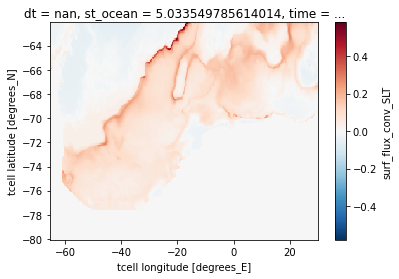

In [95]:
surf.surf_flux_conv_SLT[0,0].plot()

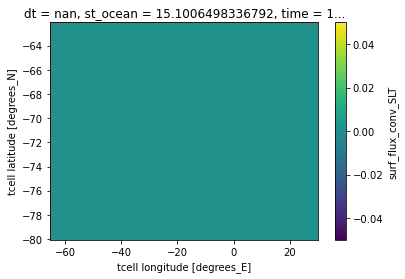

In [97]:
surf.surf_flux_conv_SLT[0,1].plot()

In [101]:
mask_surf = surf.surf_flux_conv_SLT != 0 

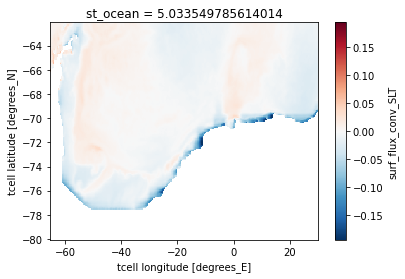

In [102]:
surf.surf_flux_conv_SLT.where(mask_surf).mean(dim='time')[0].plot()

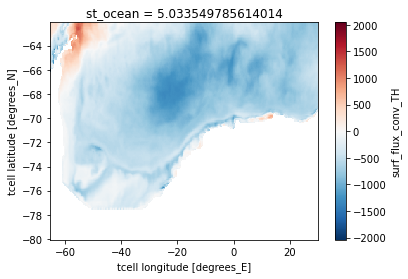

In [104]:
surf.surf_flux_conv_TH.where(mask_surf).mean(dim='time')[0].plot()

In [106]:
surf.surf_flux_conv_TH[0,0].isnull().values

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [107]:
surf.surf_flux_conv_SLT[1:]

<xarray.DataArray 'surf_flux_conv_SLT' (time: 1969, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<getitem, shape=(1969, 50, 169, 381), dtype=float64, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
    dt        (time) float32 4.32e+05 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [108]:
surf.surf_flux_conv_TH[1:]

<xarray.DataArray 'surf_flux_conv_TH' (time: 1969, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<getitem, shape=(1969, 50, 169, 381), dtype=float64, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
    dt        (time) float32 4.32e+05 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [113]:
surf.sw_flux_conv_TH[1:].drop('dt').coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [109]:
sigma2[1:].coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00

In [114]:
omega_surf_TH = - (histogram(sigma2[1:].rename('sigma2'), bins=[sigma_bins],
                             weights=surf.surf_flux_conv_TH[1:].drop('dt').fillna(0.), dim=['xt_ocean', 'yt_ocean', 'st_ocean']) / (-delta_sigma))
omega_surf_TH.load()

omega_sw_TH = - (histogram(sigma2[1:].rename('sigma2'), bins=[sigma_bins],
                           weights=surf.sw_flux_conv_TH[1:].drop('dt').fillna(0.), dim=['xt_ocean', 'yt_ocean', 'st_ocean']) / (-delta_sigma))
omega_sw_TH.load()

omega_surf_SLT = - (histogram(sigma2[1:].rename('sigma2'), bins=[sigma_bins],
                              weights=surf.surf_flux_conv_SLT[1:].drop('dt').fillna(0.), dim=['xt_ocean', 'yt_ocean', 'st_ocean']) / (-delta_sigma))
omega_surf_SLT.load()

omega_surf = omega_surf_TH + omega_sw_TH + omega_surf_SLT
omega_surf.load()

<xarray.DataArray 'histogram_sigma2' (time: 1969, sigma2_bin: 699)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03

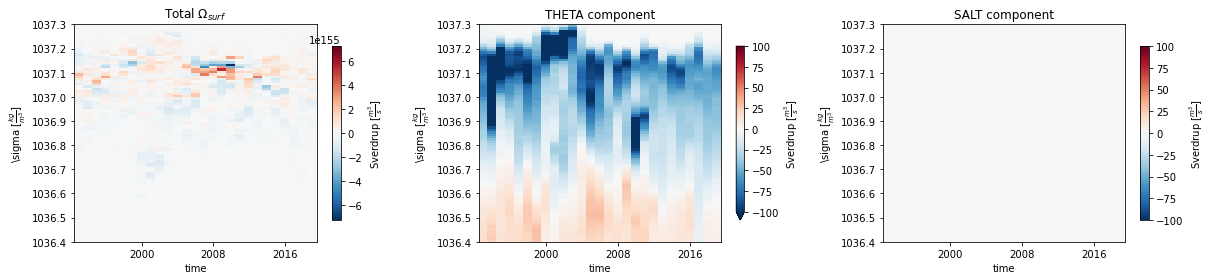

In [116]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

(omega_surf.resample(time='AS').mean()/1e6).plot(x='time', ax=ax0,
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylim(1036.4, 1037.3)
ax0.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax0.set_title(r'Total $\Omega_{surf}$')

(omega_surf_TH.resample(time='AS').mean()/1e6).plot(x='time', ax=ax1, vmax=100,
                                                          cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylim(1036.4, 1037.3)
ax1.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax1.set_title('THETA component')

(omega_surf_SLT.resample(time='AS').mean()/1e6).plot(x='time', ax=ax2, vmax=100,
                                                           cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylim(1036.4, 1037.3)
ax2.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax2.set_title('SALT component')

plt.tight_layout();

## <font color='Green'> \begin{equation*} NO\ \Psi_{adv} = \Psi_{vel} + R2 \end{equation*} </font>

## <font color='Green'>\begin{equation*} Transport/Vel\ terms \end{equation*}</font>

## <font color='Green'>\begin{equation*} \Psi_{vel} = \vec{\textbf{u}} \cdot \nabla \theta \end{equation*}</font>

In [124]:
grid_transport = xgcm.Grid(transport, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'}, 
                                              'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                                              'T': {'center': 'time'},
                                              'Z': {'center': 'st_edges_ocean', 'right': 'st_ocean'},
                                              'Zu': {'center': 'sw_edges_ocean', 'right': 'sw_ocean'}},
                     periodic=['X'])
grid_transport

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   st_edges_ocean --> right
  * right    st_ocean --> center
Zu Axis (not periodic, boundary=None):
  * center   sw_edges_ocean --> right
  * right    sw_ocean --> center

In [143]:
u_transport_right = (transport.tx_trans * cells.dz * cells.dy_u).isel(xu_ocean=-1)
u_transport_left = (transport.tx_trans * cells.dz * cells.dy_u).isel(xu_ocean=0)

v_transport = (transport.ty_trans * cells.dz * cells.dx_u).isel(yu_ocean=-1)

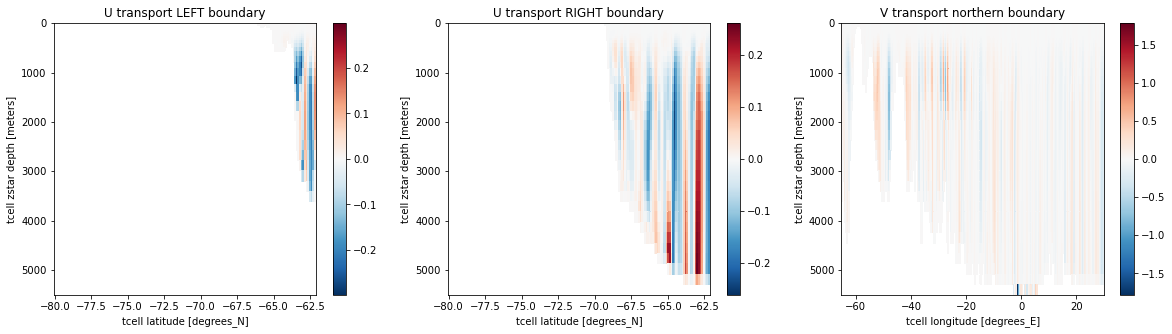

In [144]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20,5))

(u_transport_left[0]/1e6).plot(yincrease=False, ax=ax0)
ax0.set_title('U transport LEFT boundary')
(u_transport_right[0]/1e6).plot(yincrease=False, ax=ax1) 
ax1.set_title('U transport RIGHT boundary')
(v_transport[0]/1e6).plot(yincrease=False, ax=ax2)
ax2.set_title('V transport northern boundary');

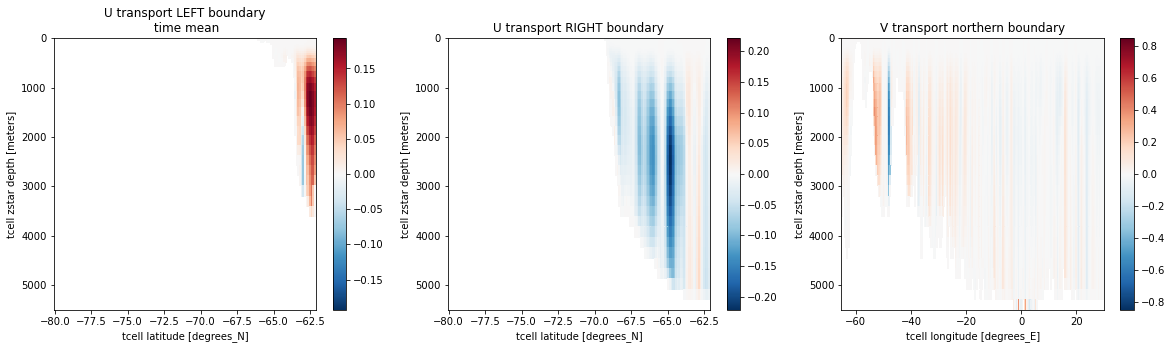

In [145]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20,5))

(u_transport_left.mean(dim='time')/1e6).plot(yincrease=False, ax=ax0)
ax0.set_title('U transport LEFT boundary\n time mean')
(u_transport_right.mean(dim='time')/1e6).plot(yincrease=False, ax=ax1) 
ax1.set_title('U transport RIGHT boundary')
(v_transport.mean(dim='time')/1e6).plot(yincrease=False, ax=ax2)
ax2.set_title('V transport northern boundary');

In [146]:
u_transport_right

<xarray.DataArray (time: 985, st_ocean: 50, yt_ocean: 169)>
dask.array<getitem, shape=(985, 50, 169), dtype=float64, chunksize=(1, 50, 169), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
    xu_ocean  float64 30.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [147]:
u_transport_left

<xarray.DataArray (time: 985, st_ocean: 50, yt_ocean: 169)>
dask.array<getitem, shape=(985, 50, 169), dtype=float64, chunksize=(1, 50, 169), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
    xu_ocean  float64 -65.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [148]:
v_transport

<xarray.DataArray (time: 985, st_ocean: 50, xt_ocean: 381)>
dask.array<getitem, shape=(985, 50, 381), dtype=float64, chunksize=(1, 50, 191), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
    yu_ocean  float64 -62.08

In [149]:
# BEST WAY TO DO IT
u_transport_mean_value = (u_transport_right.fillna(0.).sum(dim=['yt_ocean', 'st_ocean']) -
                          u_transport_left.fillna(0.).sum(dim=['yt_ocean', 'st_ocean'])).mean(dim='time')/1e6
u_transport_mean_value.load()

<xarray.DataArray ()>
array(-69.76946809)

In [150]:
v_transport_mean_value = (v_transport).fillna(0.).sum(dim=['xt_ocean', 'st_ocean']).mean(dim='time')/1e6
v_transport_mean_value.load()

<xarray.DataArray ()>
array(71.82896706)
Coordinates:
    yu_ocean  float64 -62.08

In [152]:
residual = u_transport_mean_value + v_transport_mean_value #+ surf_transport_mean_value
residual

<xarray.DataArray ()>
array(2.05949897)
Coordinates:
    yu_ocean  float64 -62.08

In [155]:
u_transport_right.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
    xu_ocean  float64 30.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [158]:
v_transport.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
    yu_ocean  float64 -62.08

In [156]:
sigma2.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00

In [160]:
horiz_transport = xr.merge((u_transport_left.rename('u_transport_left'),
                            u_transport_right.rename('u_transport_right'),
                            v_transport.rename('v_transport')), compat='override')

In [161]:
horiz_transport

<xarray.Dataset>
Dimensions:            (st_ocean: 50, time: 985, xt_ocean: 381, yt_ocean: 169)
Coordinates:
  * st_ocean           (st_ocean) float64 5.034 15.1 ... 5.185e+03 5.395e+03
  * time               (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
    xu_ocean           float64 -65.0
  * yt_ocean           (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.25 -62.14
  * xt_ocean           (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.62 29.88
    yu_ocean           float64 -62.08
Data variables:
    u_transport_left   (time, st_ocean, yt_ocean) float64 dask.array<chunksize=(1, 50, 169), meta=np.ndarray>
    u_transport_right  (time, st_ocean, yt_ocean) float64 dask.array<chunksize=(1, 50, 169), meta=np.ndarray>
    v_transport        (time, st_ocean, xt_ocean) float64 dask.array<chunksize=(1, 50, 191), meta=np.ndarray>

In [201]:
#resample sigma2 to same timestep as transport, then interp transport terms timestamp to sigma2
sigma2_resample = sigma2.resample(time='10D').mean()
horiz_transport_interp = horiz_transport.interp(time=sigma2_resample.time)
u_left_time_interp = u_transport_left.interp(time=sigma2_resample.time)
u_right_time_interp = u_transport_right.interp(time=sigma2_resample.time)
v_time_interp = v_transport.interp(time=sigma2_resample.time)

In [167]:
sigma2_resample.time

<xarray.DataArray 'time' (time: 985)>
array([cftime.DatetimeJulian(1993, 1, 4, 0, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 14, 0, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 24, 0, 0, 0, 0), ...,
       cftime.DatetimeJulian(2019, 11, 24, 0, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 4, 0, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 14, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1993-01-04 00:00:00 ... 2019-12-14 00:00:00

In [170]:
horiz_transport_interp.time

<xarray.DataArray 'time' (time: 985)>
array([cftime.DatetimeJulian(1993, 1, 4, 0, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 14, 0, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 24, 0, 0, 0, 0), ...,
       cftime.DatetimeJulian(2019, 11, 24, 0, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 4, 0, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 14, 0, 0, 0, 0)], dtype=object)
Coordinates:
    xu_ocean  float64 -65.0
    yu_ocean  float64 -62.08
  * time      (time) object 1993-01-04 00:00:00 ... 2019-12-14 00:00:00

In [188]:
#interp sigma2 to transport boundary faces
sigma_at_u_right = grid_transport.interp(sigma2_resample, 'X').isel(xu_ocean=-1)
sigma_at_u_left = grid_transport.interp(sigma2_resample, 'X').isel(xu_ocean=0)
sigma_at_v = grid_transport.interp(sigma2_resample, 'Y', boundary='fill').isel(yu_ocean=-1)

In [195]:
sigma_at_u_right.coords

Coordinates:
  * time      (time) object 1993-01-04 00:00:00 ... 2019-12-14 00:00:00
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
    xu_ocean  float64 30.0

In [197]:
horiz_transport_interp.u_transport_right.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
    xu_ocean  float64 -65.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
    yu_ocean  float64 -62.08
  * time      (time) object 1993-01-04 00:00:00 ... 2019-12-14 00:00:00

In [202]:
u_right_time_interp.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
    xu_ocean  float64 30.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 00:00:00 ... 2019-12-14 00:00:00

In [206]:
sigma_at_u_left.coords

Coordinates:
  * time      (time) object 1993-01-04 00:00:00 ... 2019-12-14 00:00:00
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
    xu_ocean  float64 -65.0

In [207]:
u_left_time_interp.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
    xu_ocean  float64 -65.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 00:00:00 ... 2019-12-14 00:00:00

In [209]:
client.restart()

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.81cbdb43a0a14c3891c966902ca7f6e7 Dashboard: /services/dask-gateway/clusters/staging.81cbdb43a0a14c3891c966902ca7f6e7/status,Cluster Workers: 30 Cores: 60 Memory: 257.70 GB


In [ ]:
#this is the delta function part of the equation above
u_binned_right = histogram(sigma_at_u_right.rename('sigma2'), bins=[sigma_bins],
                           weights=u_right_time_interp.fillna(0.), dim=['st_ocean', 'yt_ocean']).load()

In [ ]:
u_binned_left = histogram(sigma_at_u_left.rename('sigma2'), bins=[sigma_bins],
                          weights=u_left_time_interp.fillna(0.), dim=['st_ocean', 'yt_ocean']).load()

In [117]:
v_binned = histogram(sigma_at_v.rename('sigma2'), bins=[sigma_bins],
                     weights=v_time_interp.fillna(0.), dim=['st_ocean', 'yt_ocean']).load()

In [119]:
#`isel` is letting cumsum act in reverse order (from densenst to lightest)
psi_vel = - (u_binned_right 
             - u_binned_left 
             + v_binned).isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
psi_vel.load()

<xarray.DataArray 'histogram_sigma2' (time: 469, sigma2_bin: 999)>
array([[      -0.        ,       -0.        ,       -0.        , ...,
        14364120.41660309, 14364120.41660309, 14364120.41660309],
       [      -0.        ,       -0.        ,       -0.        , ...,
         7607012.98042297,  7607012.98042297,  7607012.98042297],
       [      -0.        ,       -0.        ,       -0.        , ...,
         6856569.73955917,  6856569.73955917,  6856569.73955917],
       ...,
       [      -0.        ,       -0.        ,       -0.        , ...,
        24277045.66781616, 24277045.66781616, 24277045.66781616],
       [      -0.        ,       -0.        ,       -0.        , ...,
        20199990.54214478, 20199990.54214478, 20199990.54214478],
       [      -0.        ,       -0.        ,       -0.        , ...,
        17745529.8565979 , 17745529.8565979 , 17745529.8565979 ]])
Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

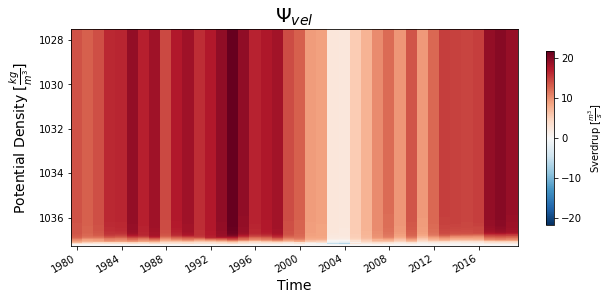

In [120]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(10,4),
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('$\Psi_{vel}$', fontsize=20)
plt.ylim(1037.3, 1027.5);

(1035.5, 1037.5)

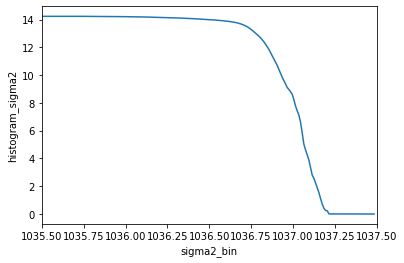

In [121]:
(psi_vel/1e6).mean(dim='time').plot()
plt.xlim(1035.5, 1037.5)

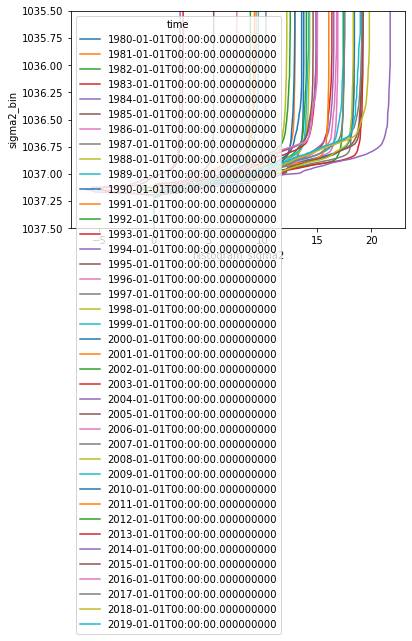

In [170]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot.line(y='sigma2_bin');#, add_legend=True)
plt.ylim(1037.5, 1035.5);

## NO R2 = $\Psi_{adv} - \Psi_{vel}$ (Numerical Mixing)

# <font color='Green'>\begin{equation*} \Omega_{tottend-truth} = \Psi_{vel} + \Omega_{surf} + R2 \end{equation*} </font>